# *Importing CSV Files*

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import seaborn as sns
from classes import LinearOrder
from utils import preprocess

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)

In [2]:
csv = {}
keywords = ['algo1', 'algo2', 'algo2i', 'optsol']
for keyword in keywords:
    for vc in range(3, 7):
        if vc <= 4:
            csv[f'{keyword}_{vc}v'] = pd.read_csv(f'results/{vc}v{keyword}.csv')
        csv[f'{keyword}_{vc}v_trees'] = pd.read_csv(f'results/{vc}v{keyword}trees.csv')

In [3]:
keywords = ['algo1', 'algo2', 'algo2i', 'optsol']
for keyword in keywords:
    dimensions = []
    for vc in range(3, 7):
        if vc <= 4:
            dimensions.append(csv[f'{keyword}_{vc}v'].shape)
        dimensions.append(csv[f'{keyword}_{vc}v_trees'].shape)
    
    print(dimensions)

[(63, 4), (12, 4), (2149, 4), (128, 4), (2000, 4), (41472, 4)]
[(63, 4), (12, 4), (2149, 4), (128, 4), (2000, 4), (41472, 4)]
[(63, 4), (12, 4), (2149, 4), (128, 4), (2000, 4), (41472, 4)]
[(63, 4), (12, 4), (2149, 4), (128, 4), (2000, 4), (41472, 4)]


# *Defining Functions*

In [4]:
def countInversions(lo_input):
    count = 0
    los = [lo.sequence for lo in preprocess(lo_input)]
    for i in range(len(los)):
        lo_ref = los[i]
        for j in range(i + 1, len(los)):
            lo = [0 for k in range(len(lo_ref))]
            for l in range(len(lo_ref)):
                lo[los[j].index(lo_ref[l])] = l
            
            count += sum(pi > lo[j]
                         for i, pi in enumerate(lo)
                         for j in range(i + 1, len(lo)))
    
    return count

def countSwapPairs(lo_input):
    count = 0
    los = [lo.relations for lo in preprocess(lo_input)]
    for i in range(len(los)):
        lo_ref = sorted(los[i])
        for j in range(i + 1, len(los)):
            lo = sorted([(b, a) for a, b in los[j]])
            count += len(set(lo_ref).intersection(set(lo)))
    
    return count

def merge(dataframes, joins):
    main = pd.merge(dataframes[0], dataframes[1], how=joins[0])
    for i in range(2, len(dataframes)):
        main = pd.merge(main, dataframes[i], how=joins[i - 1])
    
    return main

def extend(dataframe, keywords=['algo1', 'algo2', 'algo2i', 'optsol']):
    dataframe['input_size'] = dataframe['input'].map(lambda x: x.count('-') + 1)
    dataframe['vertex_count'] = dataframe['input'].map(lambda x: x.split('-')[0].count(',') + 1)
    dataframe['num_inversion'] = dataframe['input'].map(lambda x: countInversions(x))
    dataframe['num_swap_pair'] = dataframe['input'].map(lambda x: countSwapPairs(x))
    
    for keyword in keywords:
        dataframe[f'num_rel_{keyword}'] = dataframe[f'output_{keyword}'].map(lambda x: str(x).count('('))
        if keyword != 'optsol':
            dataframe[f'approx_{keyword}'] = dataframe.apply(lambda x: 
                                                             x[f'cost_{keyword}']/x[f'cost_optsol'], axis=1)
            dataframe[f'cost_diff_{keyword}'] = dataframe.apply(lambda x: 
                                                                abs(x[f'cost_{keyword}'] - x[f'cost_optsol']), axis=1)

In [13]:
def getApproxVsVal(dataframe, algorithm, attribute, value, operator='eq'):
    column = f'{attribute}_{algorithm}'
    if operator == 'eq':
        approx = dataframe[dataframe[column] == value]
    elif operator == 'neq':
        approx = dataframe[dataframe[column] != value]
    elif operator == 'gt':
        approx = dataframe[dataframe[column] > value]
    elif operator == 'lt':
        approx = dataframe[dataframe[column] < value]
    
    return approx

def getApproxVsApprox(dataframe, algorithm1, algorithm2, attribute, operator='eq'):
    column1 = f'{attribute}_{algorithm1}'
    column2 = f'{attribute}_{algorithm2}'
    if operator == 'eq':
        approx = dataframe[dataframe[column1] == dataframe[column2]]
    if operator == 'neq':
        approx = dataframe[dataframe[column1] != dataframe[column2]]
    if operator == 'gt':
        approx = dataframe[dataframe[column1] > dataframe[column2]]
    if operator == 'lt':
        approx = dataframe[dataframe[column1] < dataframe[column2]]
    
    return approx

In [6]:
def plotScatters(dataframe, columns):
    analysis = dataframe[columns]
    fig, axs = plt.subplots(nrows=(len(columns) - 1),
                            figsize=(7, (7 * (len(columns) - 1))))
    for i in range(1, len(columns)):
        sns.regplot(x=columns[0], y=columns[i], data=analysis, ax=axs[i - 1])
        slope, intercept, r_value, p_value, std_err = sc.stats.linregress(x=axs[i - 1].get_lines()[0].get_xdata(),
                                                                          y=axs[i - 1].get_lines()[0].get_ydata())
    
        print(f"axs[{i - 1}] : y = {slope:.5f}x + {intercept:.5f}")

# *Analysis according to Vertex Count*

In [7]:
results_vc = {}
joins_all = ['inner', 'inner', 'inner']
keywords = ['algo1', 'algo2', 'algo2i', 'optsol']
for vc in range(3, 5):
    results_vc[f'all{vc}'] = merge([csv[f'{keyword}_{vc}v'] for keyword in keywords], joins_all)

results_vc['allv'] = merge([results_vc['all3'], results_vc['all4']], ['outer'])
results_vc['optsol'] = merge([csv[f'optsol_{vc}v'] for vc in range(3, 5)], ['outer'])
                            
joins_algo = ['outer', 'inner']
for keyword in keywords:
    results_vc[keyword] = merge([csv[f'{keyword}_{vc}v'] for vc in range(3, 5)] + [results_vc['optsol']], 
                                joins_algo)

In [8]:
for key in results_vc.keys():
    if 'all' in key:
        extend(results_vc[key])
    elif 'optsol' in key:
        extend(results_vc[key], ['optsol'])
    elif 'algo2i' in key:
        extend(results_vc[key], ['algo2i'])
    elif 'algo1' in key:
        extend(results_vc[key], ['algo1'])
    elif 'algo2' in key:
        extend(results_vc[key], ['algo2'])

In [9]:
dimensions = []
for vc in range(3, 5):
    dimensions.append(results_vc[f'all{vc}'].shape)
dimensions.append(results_vc['allv'].shape)

print(dimensions[:4])

keywords = ['algo1', 'algo2', 'algo2i', 'optsol']
for keyword in keywords:
    dimensions.append(results_vc[f'{keyword}'].shape)
    
print(dimensions[3:])

[(63, 27), (2149, 27), (2212, 27)]
[(2212, 14), (2212, 14), (2212, 14), (2212, 9)]


input_size, runtime
axs[0] : y = 0.00043x + -0.00149
axs[1] : y = 0.00028x + -0.00120
axs[2] : y = 0.00001x + 0.00004
axs[3] : y = 81.72959x + -548.64914

input_size, cost
axs[0] : y = 0.23389x + 3.11878
axs[1] : y = 1.45978x + -2.63095
axs[2] : y = 0.36696x + 2.24680
axs[3] : y = 0.10106x + 3.40839

input_size, num_rel
axs[0] : y = 0.76879x + 9.25981
axs[1] : y = 6.98824x + -8.00473
axs[2] : y = 1.71732x + 14.38314
axs[3] : y = 0.06677x + 21.15441

num_inversion, runtime
axs[0] : y = 0.00001x + 0.00052
axs[1] : y = 0.00001x + 0.00002
axs[2] : y = 0.00000x + 0.00011
axs[3] : y = 2.46274x + -228.19284

num_inversion, cost
axs[0] : y = 0.00513x + 4.53422
axs[1] : y = 0.03990x + 4.15355
axs[2] : y = 0.00897x + 4.22911
axs[3] : y = 0.00161x + 4.17813

num_inversion, num_rel
axs[0] : y = 0.01695x + 13.88914
axs[1] : y = 0.18879x + 25.05508
axs[2] : y = 0.04049x + 24.04263
axs[3] : y = -0.00457x + 23.12760

num_swap_pair, runtime
axs[0] : y = 0.00001x + 0.00052
axs[1] : y = 0.00001x + 0.0000

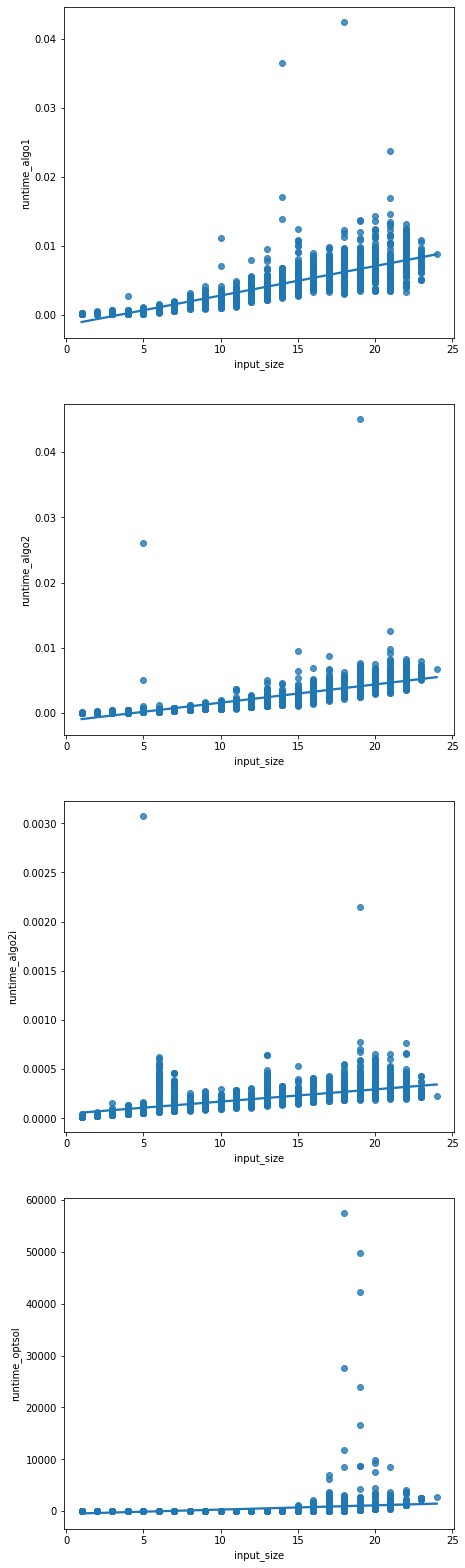

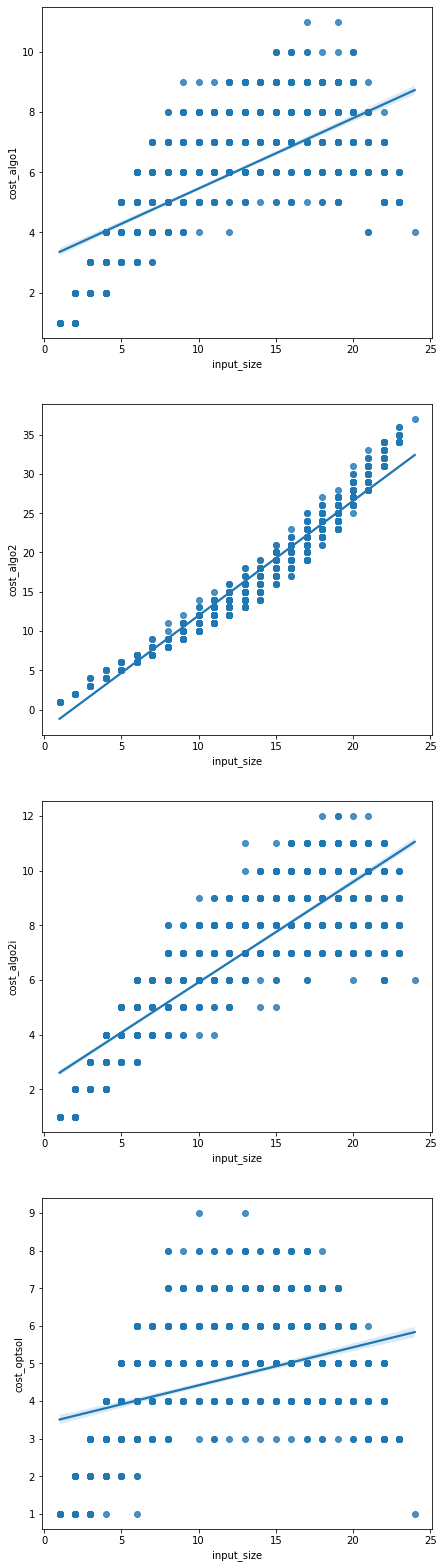

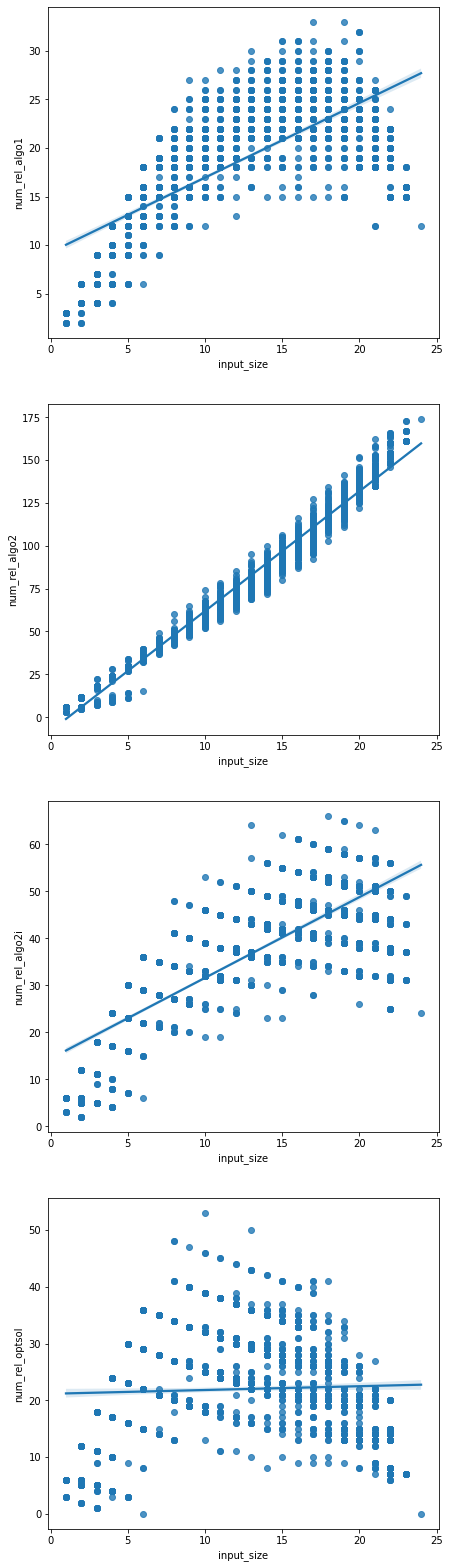

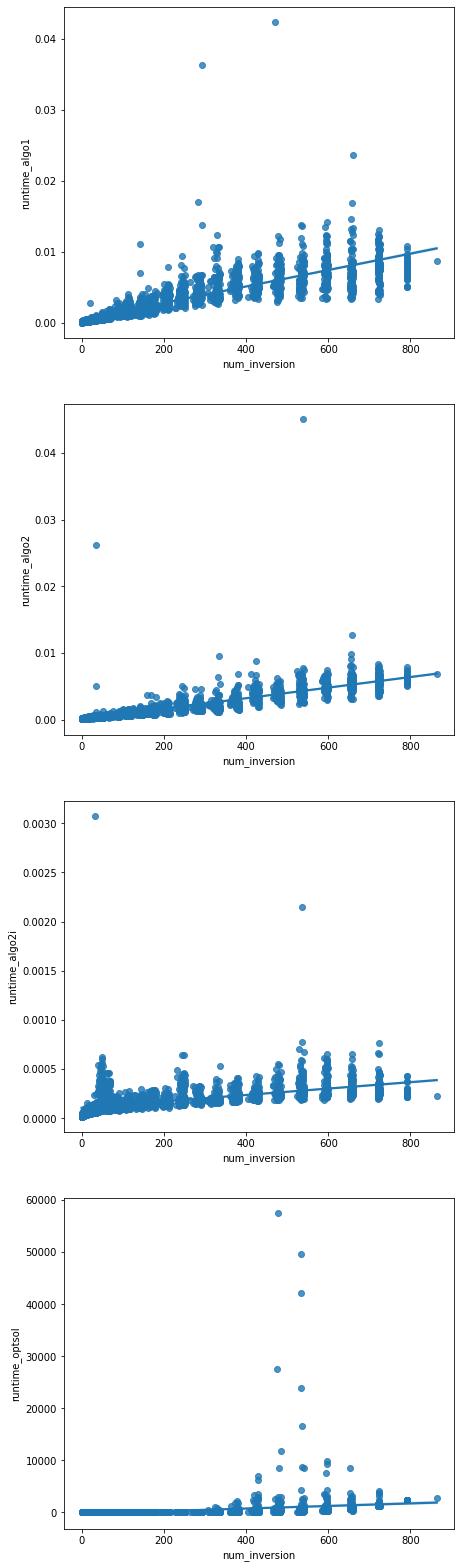

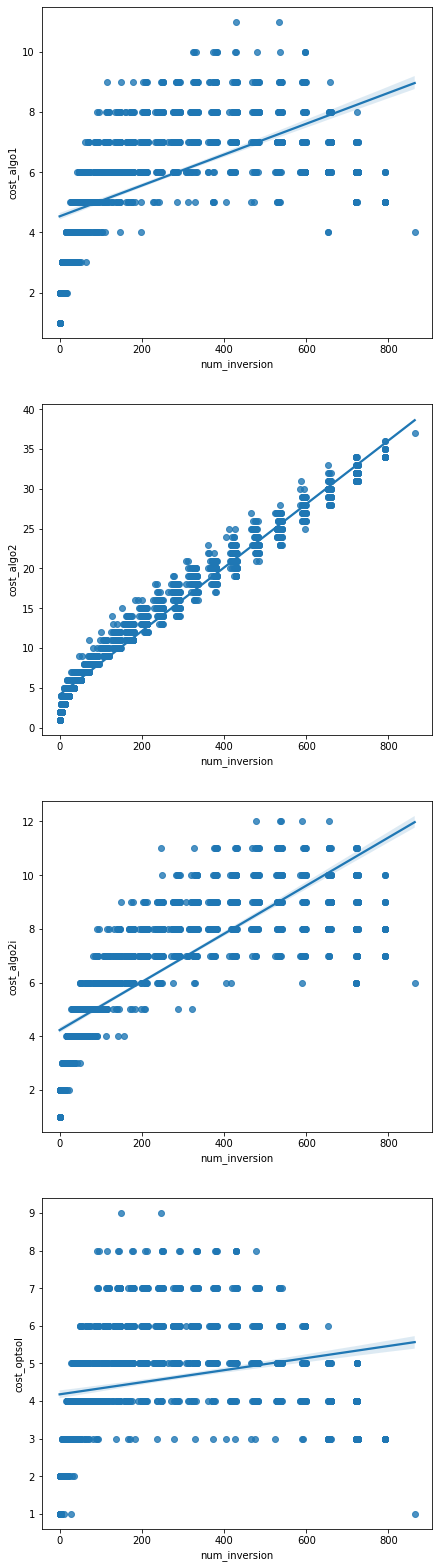

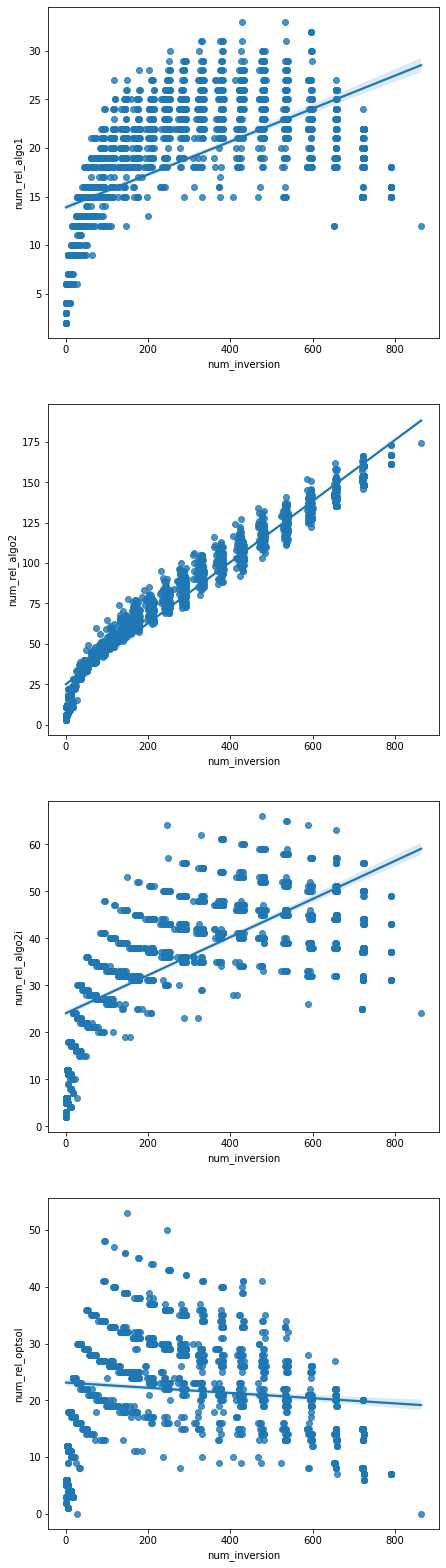

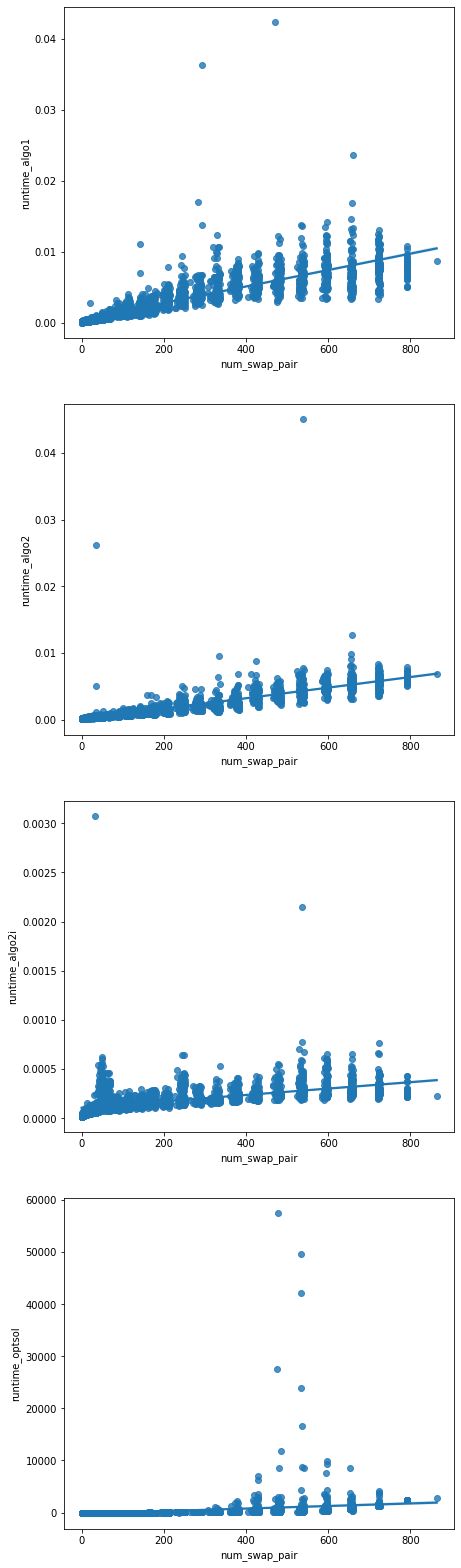

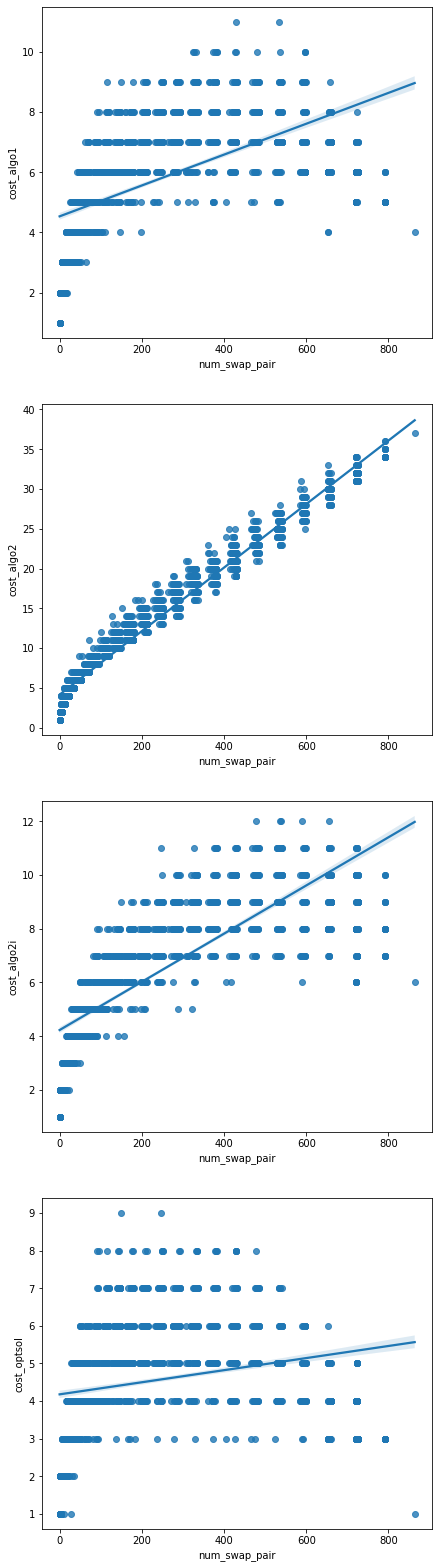

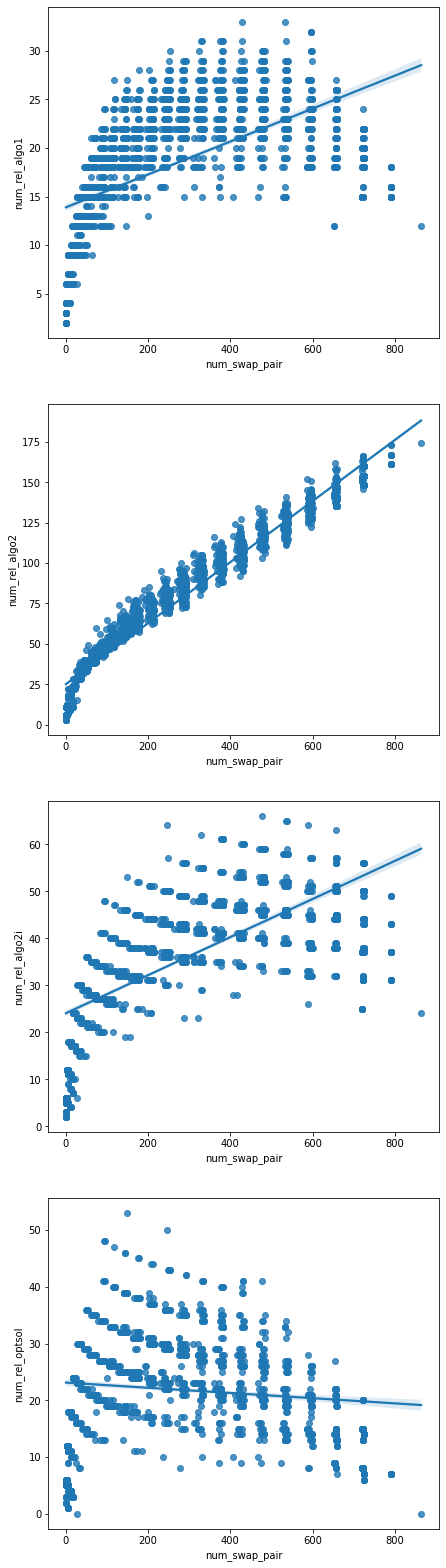

In [10]:
keywords = ['algo1', 'algo2', 'algo2i', 'optsol']
x_attributes = ['input_size', 'num_inversion', 'num_swap_pair']
y_attributes = ['runtime', 'cost', 'num_rel']
for x_attribute in x_attributes:
    for y_attribute in y_attributes:
        print(f'{x_attribute}, {y_attribute}')
        plotScatters(results_vc['allv'], 
                     [x_attribute] + [f'{y_attribute}_{keyword}' for keyword in keywords])
        print('')

In [21]:
optapprox = {}
keywords = ['algo1', 'algo2', 'algo2i']
for keyword in keywords:
    optapprox[keyword] = getApproxVsVal(results_vc[keyword], keyword, 'cost_diff', 0)
    
for keyword in keywords:
    optapprox_algo = optapprox[keyword]
    for vc in range(3, 5):
        print(optapprox_algo[optapprox_algo['vertex_count'] == vc].shape)
    print(optapprox_algo.shape)
    print('---')

(29, 14)
(687, 14)
(716, 14)
---
(17, 14)
(247, 14)
(264, 14)
---
(43, 14)
(671, 14)
(714, 14)
---


In [22]:
nonoptapprox = {}
keywords = ['algo1', 'algo2', 'algo2i']
for keyword in keywords:
    nonoptapprox[keyword] = getApproxVsVal(results_vc[keyword], keyword, 'cost_diff', 0, 'neq')
    
for keyword in keywords:
    nonoptapprox_algo = nonoptapprox[keyword]
    for vc in range(3, 5):
        print(nonoptapprox_algo[nonoptapprox_algo['vertex_count'] == vc].describe())
    print('')
    print(optapprox_algo.describe())
    print('---')

       cost_algo1  runtime_algo1  cost_optsol  runtime_optsol  input_size  \
count   34.000000      34.000000    34.000000       34.000000   34.000000   
mean     2.735294       0.000143     1.705882        0.000545    3.705882   
std      0.447811       0.000037     0.462497        0.000465    0.970143   
min      2.000000       0.000079     1.000000        0.000114    2.000000   
25%      2.250000       0.000124     1.000000        0.000245    3.000000   
50%      3.000000       0.000142     2.000000        0.000359    4.000000   
75%      3.000000       0.000167     2.000000        0.000547    4.000000   
max      3.000000       0.000255     2.000000        0.001761    6.000000   

       vertex_count  num_inversion  num_swap_pair  num_rel_algo1  \
count          34.0      34.000000      34.000000      34.000000   
mean            3.0       9.705882       9.705882       5.470588   
std             0.0       6.137463       6.137463       0.895622   
min             3.0       1.000000

       cost_algo2i  runtime_algo2i  cost_optsol  runtime_optsol   input_size  \
count  1478.000000     1478.000000  1478.000000     1478.000000  1478.000000   
mean      7.962788        0.000231     5.039242      615.831168    15.106225   
std       1.671165        0.000114     1.212026     2640.301845     4.685818   
min       2.000000        0.000034     1.000000        0.000589     3.000000   
25%       7.000000        0.000160     4.000000        1.810920    12.000000   
50%       8.000000        0.000215     5.000000       63.384434    15.000000   
75%       9.000000        0.000269     6.000000      613.783879    19.000000   
max      12.000000        0.002148     9.000000    57495.438839    24.000000   

       vertex_count  num_inversion  num_swap_pair  num_rel_algo2i  \
count        1478.0    1478.000000    1478.000000     1478.000000   
mean            4.0     367.604871     367.604871       41.479026   
std             0.0     209.163992     209.163992        8.702907   
min

In [25]:
sameapprox = {}
keywords = ['algo1', 'algo2', 'algo2i']
for i in range(len(keywords)):
    for j in range(i + 1, len(keywords)):
        sameapprox[f'{keywords[i]}_{keywords[j]}'] = getApproxVsApprox(results_vc['allv'], keywords[i], keywords[j],
                                                                       'cost')
for key in sameapprox.keys():
    print(f'{sameapprox[key].shape} - {key}')

(339, 27) - algo1_algo2
(915, 27) - algo1_algo2i
(264, 27) - algo2_algo2i


## Trees

In [11]:
results_trees = {}
joins_allvc = ['inner', 'inner', 'inner']
keywords = ['algo1', 'algo2', 'algo2i', 'optsol']
for vc in range(3, 7):
    results_trees[f'all{vc}'] = merge([csv[f'{keyword}_{vc}v_trees'] for keyword in keywords], joins_all)

joins_allv_optsol = ['outer' for vc in range(3, 6)]
results_trees['allv'] = merge([results_trees[f'all{vc}'] for vc in range(3, 7)], joins_allv_optsol)
results_trees['optsol'] = merge([csv[f'optsol_{vc}v_trees'] for vc in range(3, 7)], joins_allv_optsol)
                            
joins_algo = ['outer' for vc in range(3, 6)] + ['inner']
for keyword in keywords:
    results_trees[keyword] = merge([csv[f'{keyword}_{vc}v_trees'] for vc in range(3, 7)] + 
                                   [results_trees['optsol']], joins_algo)

In [12]:
for key in results_trees.keys():
    if 'all' in key:
        extend(results_trees[key])
    elif 'optsol' in key:
        extend(results_trees[key], ['optsol'])
    elif 'algo2i' in key:
        extend(results_trees[key], ['algo2i'])
    elif 'algo1' in key:
        extend(results_trees[key], ['algo1'])
    elif 'algo2' in key:
        extend(results_trees[key], ['algo2'])

In [18]:
dimensions = []
for vc in range(3, 7):
    dimensions.append(results_trees[f'all{vc}'].shape)
dimensions.append(results_trees['allv'].shape)

print(dimensions[:6])

keywords = ['algo1', 'algo2', 'algo2i', 'optsol']
for keyword in keywords:
    dimensions.append(results_trees[f'{keyword}'].shape)
    
print(dimensions[6:])

[(12, 27), (128, 27), (2000, 27), (41472, 27), (43612, 27)]
[(43612, 14), (43612, 14), (43612, 9)]


input_size, runtime
axs[0] : y = 0.00090x + -0.01069
axs[1] : y = 0.00154x + -0.01798
axs[2] : y = 0.00003x + -0.00012
axs[3] : y = 0.00001x + 0.00581

input_size, cost
axs[0] : y = 0.02191x + 1.62616
axs[1] : y = 2.83433x + -13.73939
axs[2] : y = 0.28374x + 1.80162
axs[3] : y = -0.00000x + 1.00000

input_size, num_rel
axs[0] : y = 0.15376x + 8.49239
axs[1] : y = 36.69729x + -171.11230
axs[2] : y = 3.81300x + 25.63943
axs[3] : y = 0.00260x + 4.89094

vertex_count, runtime
axs[0] : y = 0.00760x + -0.03644
axs[1] : y = 0.01372x + -0.06610
axs[2] : y = 0.00034x + -0.00143
axs[3] : y = 0.00538x + -0.02589

vertex_count, cost
axs[0] : y = 0.29499x + 0.34825
axs[1] : y = 35.05857x + -160.60426
axs[2] : y = 4.38624x + -18.11417
axs[3] : y = 0.00000x + 1.00000

vertex_count, num_rel
axs[0] : y = 3.86922x + -11.17545
axs[1] : y = 498.71389x + -2339.05281
axs[2] : y = 73.99010x + -331.48332
axs[3] : y = 1.00000x + -1.00000

num_inversion, runtime
axs[0] : y = 0.00001x + -0.00136
axs[1] : y = 0.0

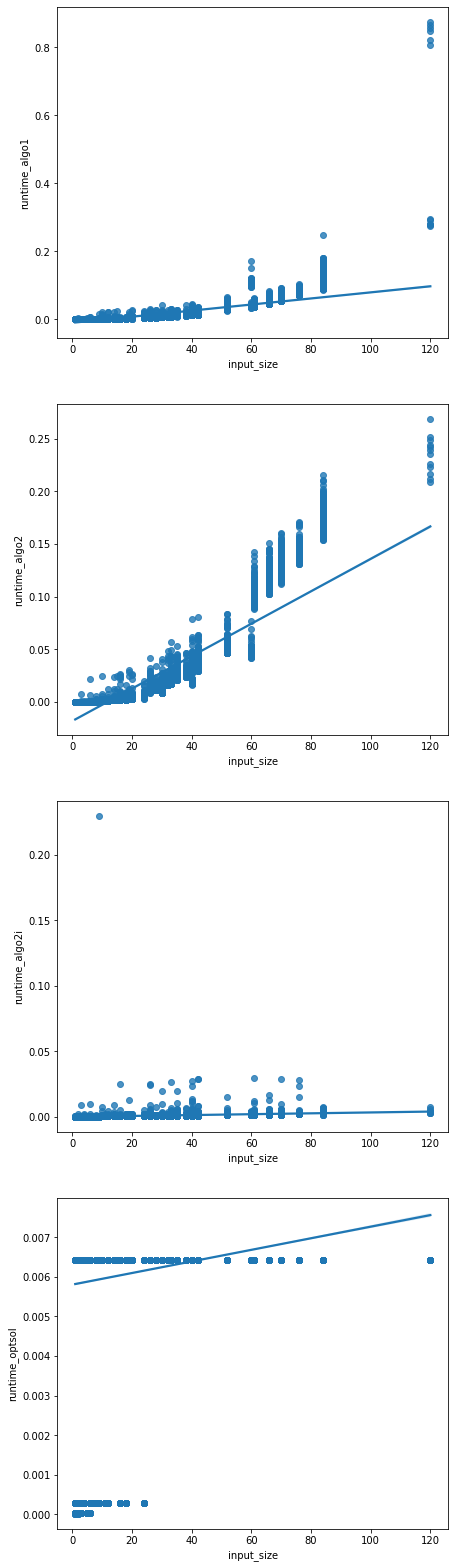

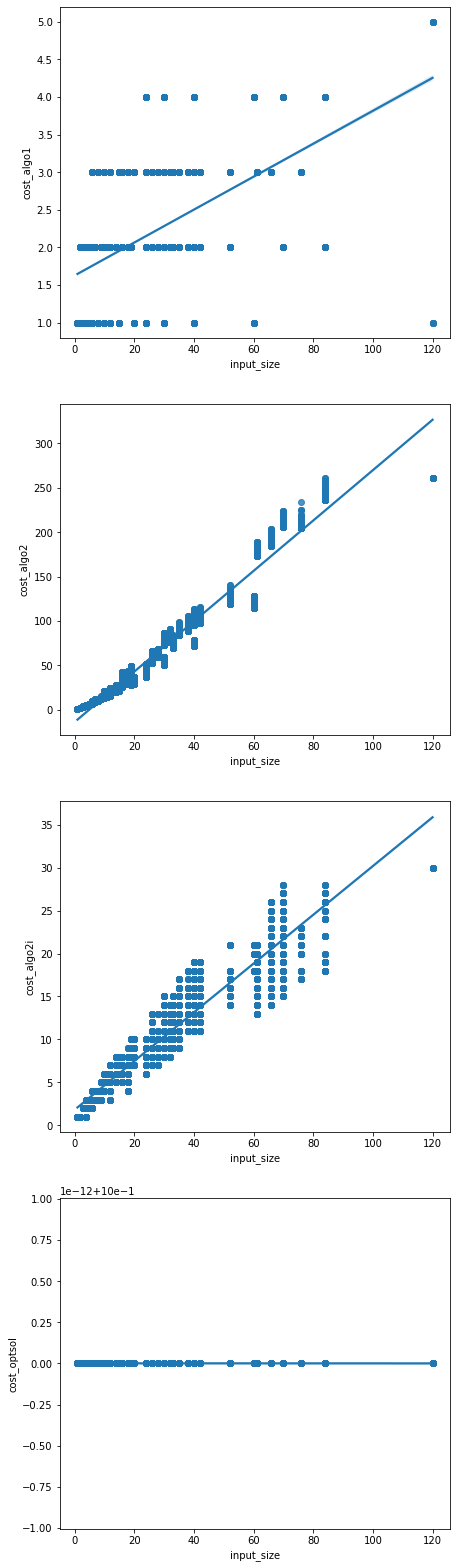

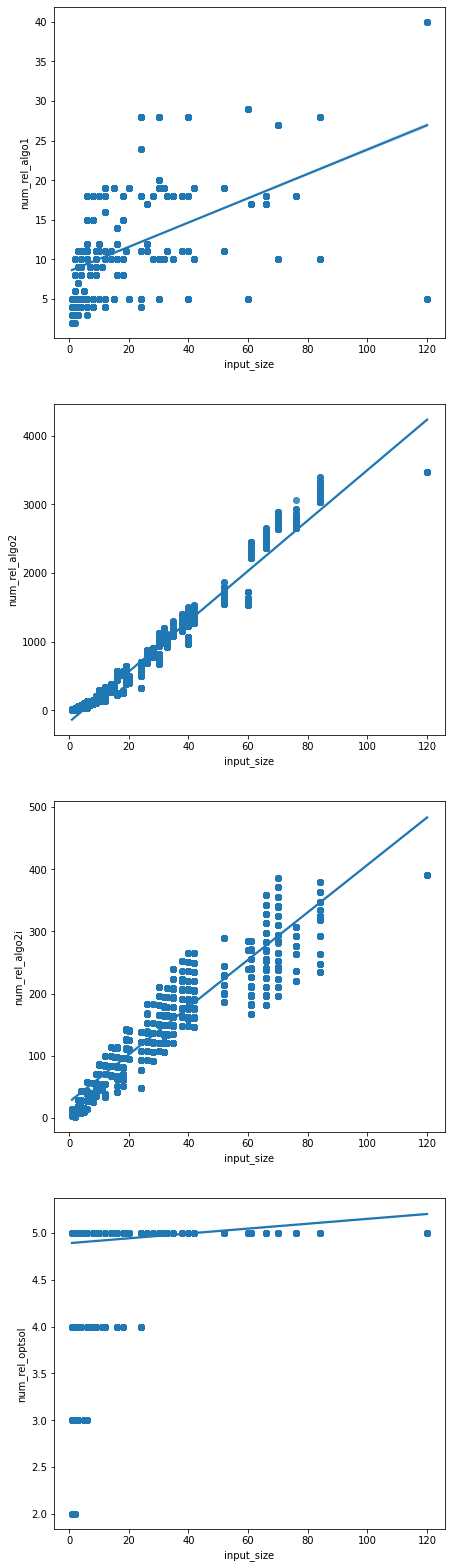

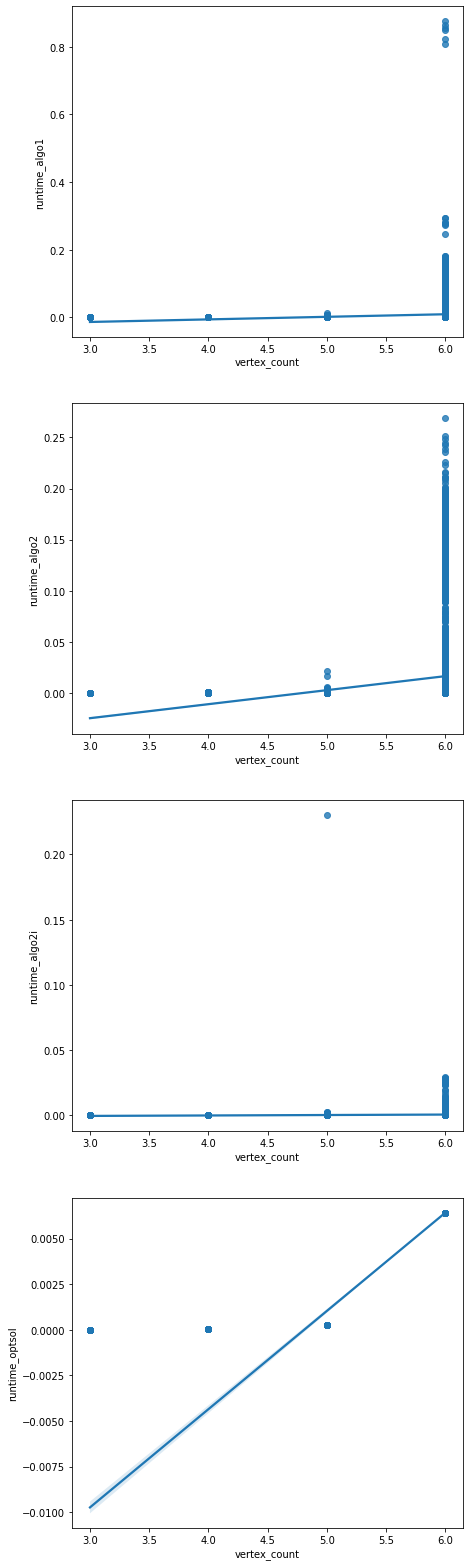

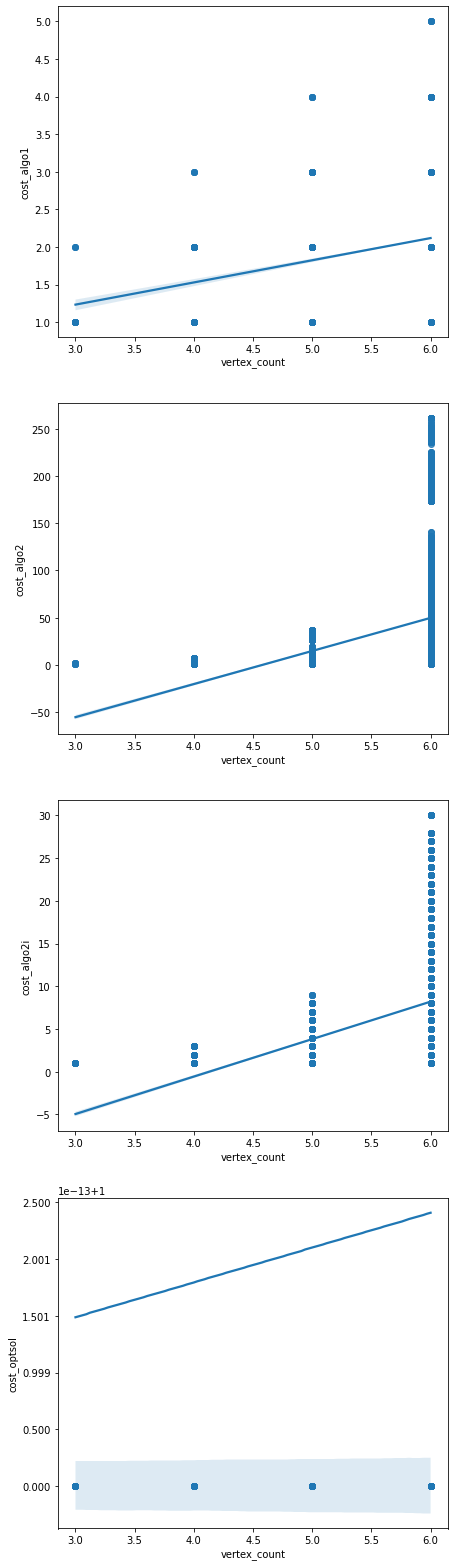

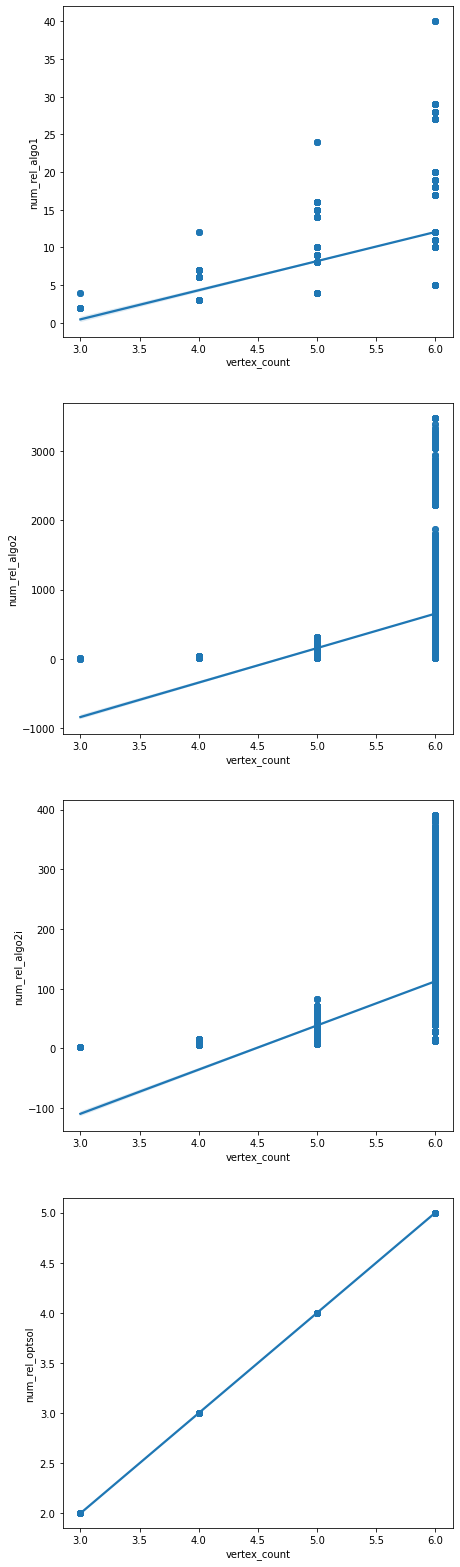

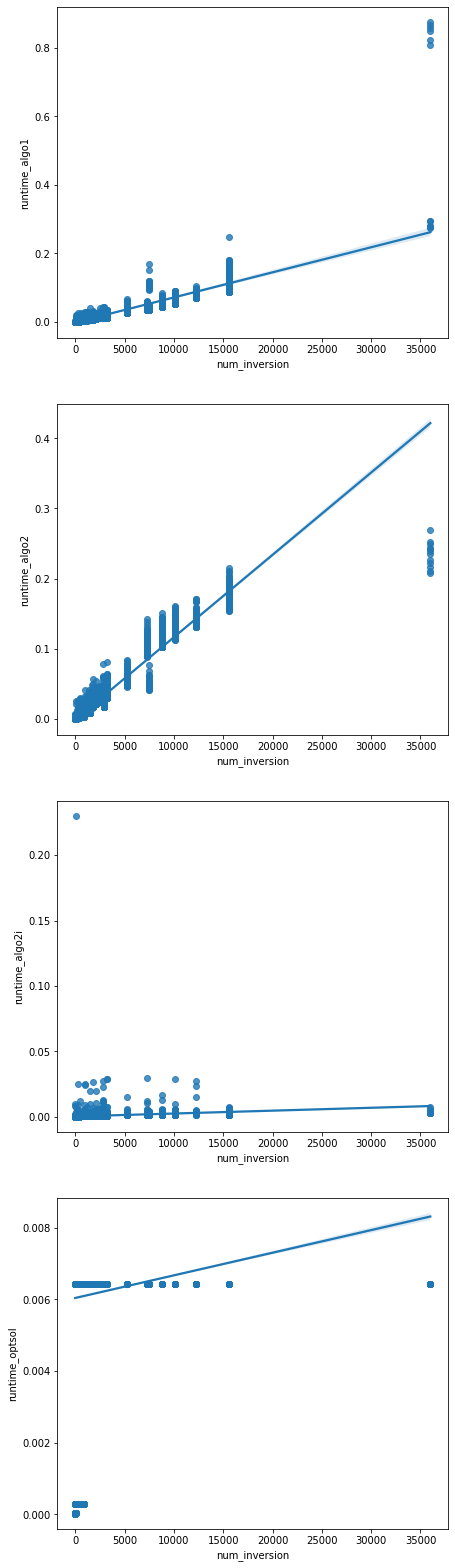

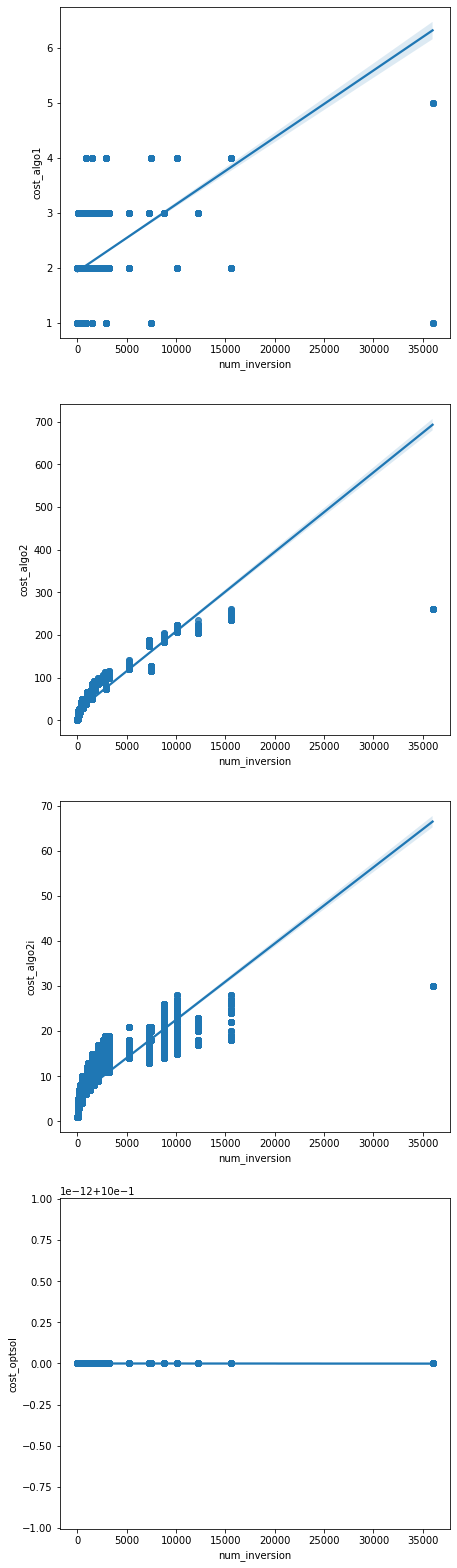

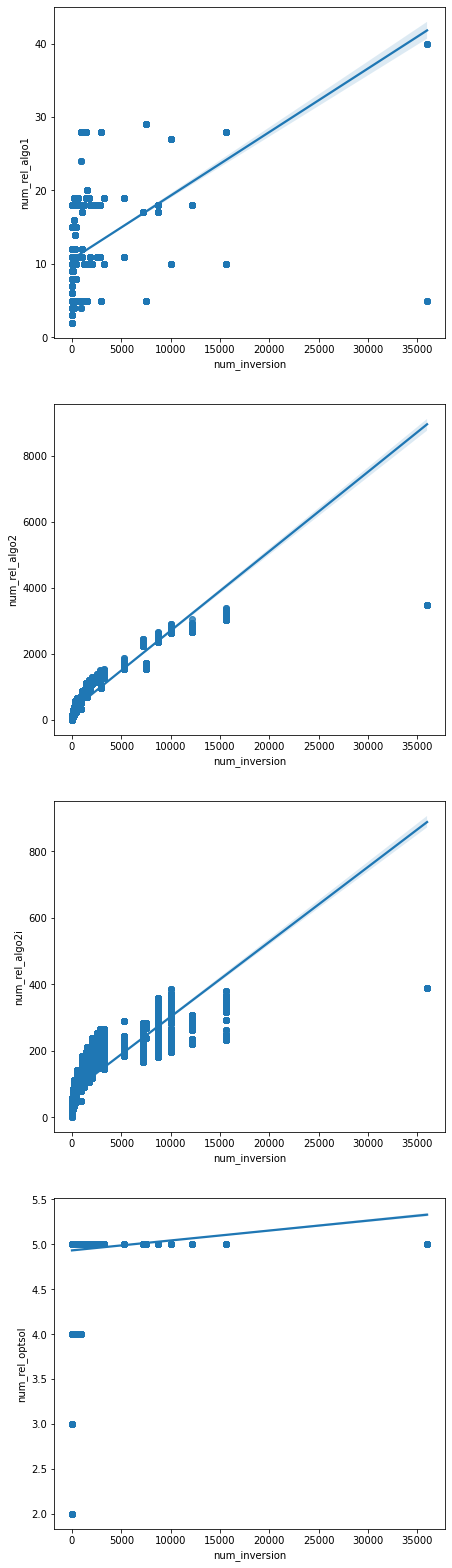

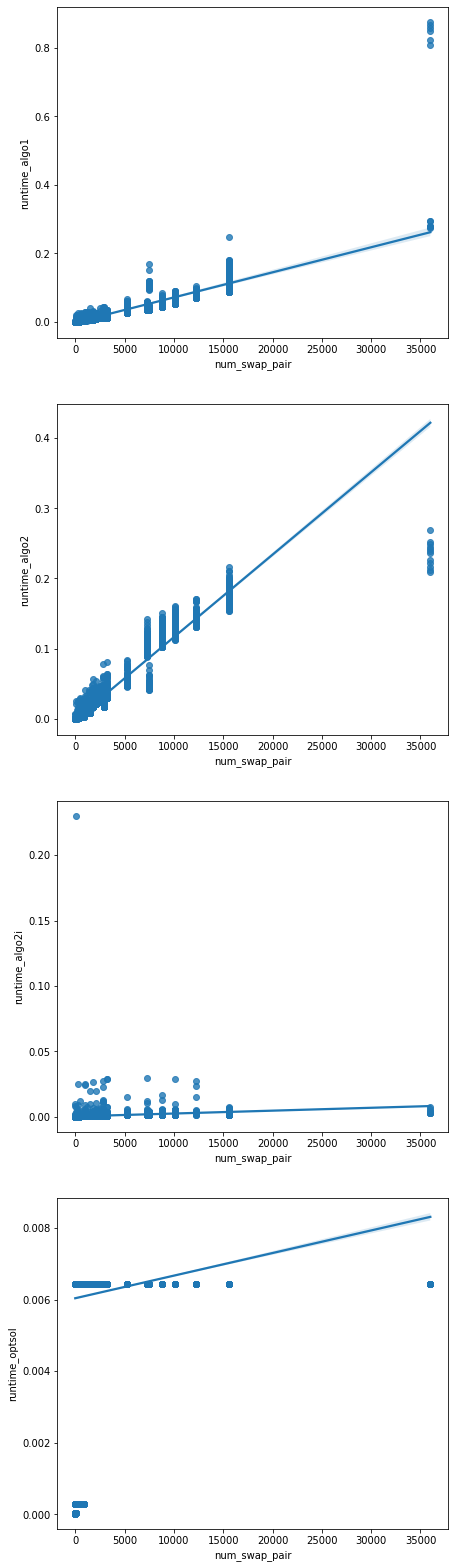

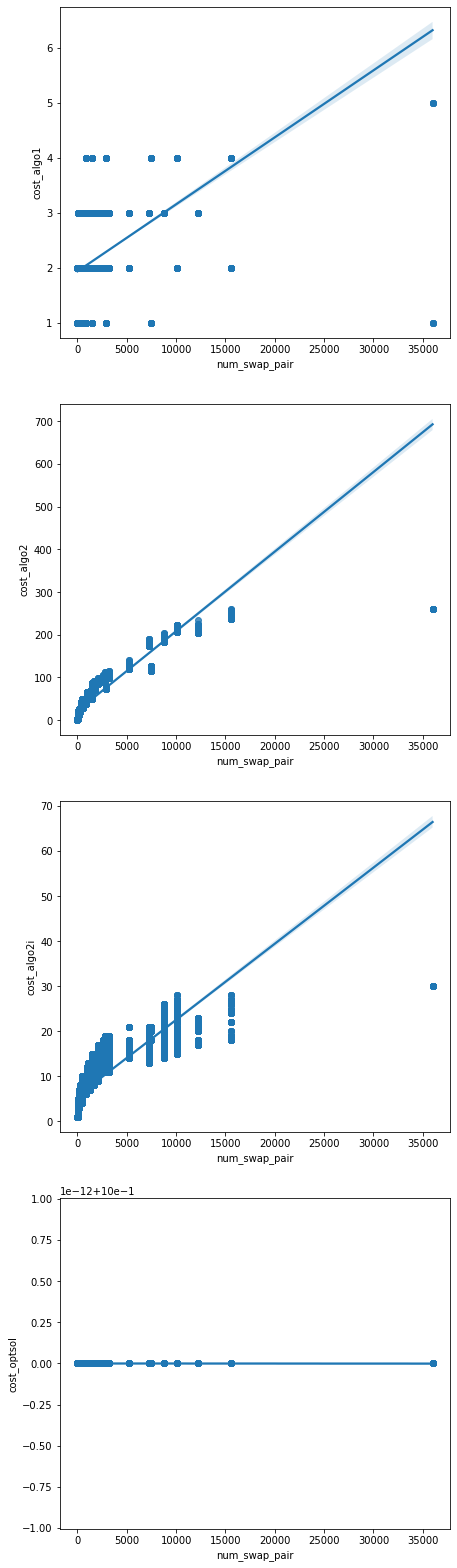

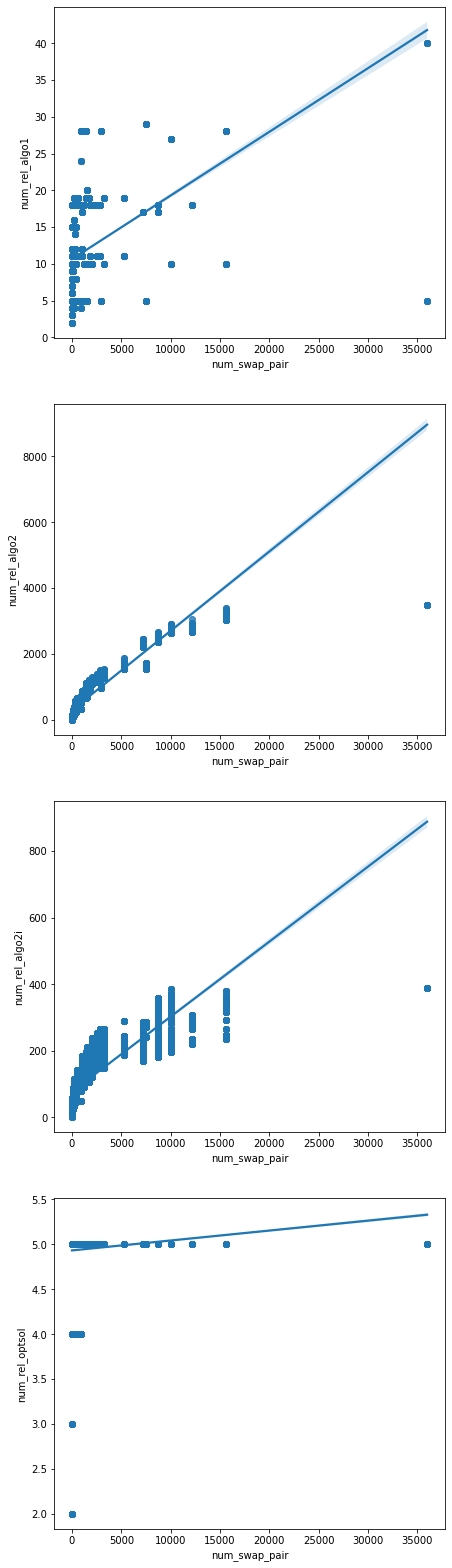

In [20]:
keywords = ['algo1', 'algo2', 'algo2i', 'optsol']
x_attributes = ['input_size', 'vertex_count', 'num_inversion', 'num_swap_pair']
y_attributes = ['runtime', 'cost', 'num_rel']
for x_attribute in x_attributes:
    for y_attribute in y_attributes:
        print(f'{x_attribute}, {y_attribute}')
        plotScatters(results_trees['allv'], 
                     [x_attribute] + [f'{y_attribute}_{keyword}' for keyword in keywords])
        print('')

In [26]:
optapprox = {}
keywords = ['algo1', 'algo2', 'algo2i']
for keyword in keywords:
    optapprox[keyword] = getApproxVsVal(results_trees[keyword], keyword, 'cost_diff', 0)
    
for keyword in keywords:
    optapprox_algo = optapprox[keyword]
    for vc in range(3, 7):
        print(optapprox_algo[optapprox_algo['vertex_count'] == vc].shape)
    print(optapprox_algo.shape)
    print('---')

(9, 14)
(64, 14)
(625, 14)
(7776, 14)
(8474, 14)
---
(6, 14)
(24, 14)
(120, 14)
(720, 14)
(870, 14)
---
(12, 14)
(48, 14)
(270, 14)
(1620, 14)
(1950, 14)
---


In [27]:
nonoptapprox = {}
keywords = ['algo1', 'algo2', 'algo2i']
for keyword in keywords:
    nonoptapprox[keyword] = getApproxVsVal(results_trees[keyword], keyword, 'cost_diff', 0, 'neq')
    
for keyword in keywords:
    nonoptapprox_algo = nonoptapprox[keyword]
    for vc in range(3, 5):
        print(nonoptapprox_algo[nonoptapprox_algo['vertex_count'] == vc].describe())
    print('')
    print(optapprox_algo.describe())
    print('---')

       cost_algo1  runtime_algo1  cost_optsol  runtime_optsol  input_size  \
count         3.0       3.000000          3.0        3.000000         3.0   
mean          2.0       0.000082          1.0        0.000009         2.0   
std           0.0       0.000021          0.0        0.000000         0.0   
min           2.0       0.000064          1.0        0.000009         2.0   
25%           2.0       0.000070          1.0        0.000009         2.0   
50%           2.0       0.000077          1.0        0.000009         2.0   
75%           2.0       0.000091          1.0        0.000009         2.0   
max           2.0       0.000104          1.0        0.000009         2.0   

       vertex_count  num_inversion  num_swap_pair  num_rel_algo1  \
count           3.0            3.0            3.0            3.0   
mean            3.0            1.0            1.0            4.0   
std             0.0            0.0            0.0            0.0   
min             3.0            1.0

In [28]:
sameapprox = {}
keywords = ['algo1', 'algo2', 'algo2i']
for i in range(len(keywords)):
    for j in range(i + 1, len(keywords)):
        sameapprox[f'{keywords[i]}_{keywords[j]}'] = getApproxVsApprox(results_trees['allv'], keywords[i], keywords[j],
                                                                       'cost')
for key in sameapprox.keys():
    print(f'{sameapprox[key].shape} - {key}')

(1305, 27) - algo1_algo2
(4225, 27) - algo1_algo2i
(870, 27) - algo2_algo2i


### TO-DO

<ul>
    <li>cost and num rel?
    <li>cost diff algo1 and algo2
    <li>cost diff algo2 and algo2i
</ul>

https://stackoverflow.com/questions/2987605/minimum-number-of-swaps-needed-to-change-array-1-to-array-2